# Detectron2 Tutorial
In this tutorial, we will use Detectron2 from Facebook AI Research (FAIR) to load our own dataset and train an object detection network.

## Register Training and Test Datasets
First, we will register our training and test datasets. Detectron2 has utilities to work with datasets formatted in the COCO format, which is commonly used.

NOTE: If you need to rerun this section, restart the Jupyter kernel first.

In [1]:
from detectron2.data.datasets import load_coco_json, register_coco_instances
from detectron2.data import MetadataCatalog

# TODO: Replace with small dataset that will be available in the repo

# Training dataset
training_dataset_name = "training_data"
training_json_file = "/home/sebastian/hsr_catkin_ws/src/csail_hsr/csail_hsr_vision/data/hsr_sim_training.json"
training_img_dir = "/home/sebastian/Workspace/coco-annotator/datasets/hsr_sim_training"
register_coco_instances(training_dataset_name, {}, training_json_file, training_img_dir)
training_dict = load_coco_json(training_json_file, training_img_dir,
                dataset_name=training_dataset_name)
training_metadata = MetadataCatalog.get(training_dataset_name)

# Test dataset
test_dataset_name = "test_data"
test_json_file = "/home/sebastian/hsr_catkin_ws/src/csail_hsr/csail_hsr_vision/data/hsr_sim_test.json"
test_img_dir = "/home/sebastian/Workspace/coco-annotator/datasets/hsr_sim_test"
register_coco_instances(test_dataset_name, {}, test_json_file, test_img_dir)
test_dict = load_coco_json(test_json_file, test_img_dir,
                dataset_name=test_dataset_name)
test_metadata = MetadataCatalog.get(test_dataset_name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



## Display Images from the Training Dataset

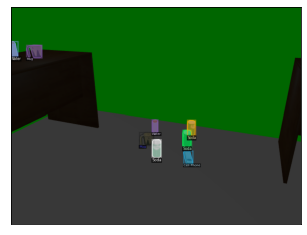

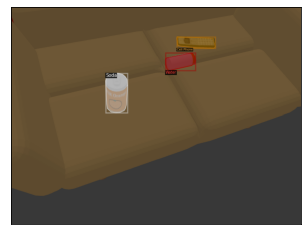

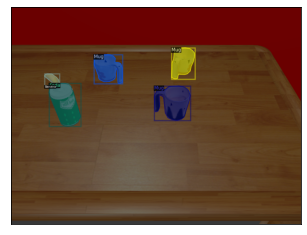

In [2]:
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline
from detectron2.utils.visualizer import Visualizer

NUM_TRAINING_SAMPLES = 3
if NUM_TRAINING_SAMPLES > 0:
    samples = random.sample(training_dict, NUM_TRAINING_SAMPLES)
    for i, sample in enumerate(samples):
        img = cv2.imread(sample["file_name"])
        visualizer = Visualizer(img, metadata=training_metadata)
        visualizer = visualizer.draw_dataset_dict(sample)
        display_img = visualizer.get_image()[:, :, ::-1]
        plt.figure(i), plt.xticks([]), plt.yticks([])
        plt.imshow(display_img)

## Set Up Training Options

In [3]:
import os
from detectron2 import model_zoo
from detectron2.config import get_cfg

# Most importantly, let's set up a model type
# These are available in the Detectron2 model zoo
#
model_type = "maskrcnn"
if model_type == "maskrcnn":
    model_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
elif model_type == "retinanet":
    model_file = "COCO-Detection/retinanet_R_50_FPN_3x.yaml"
    
# Create a configuration and set up the model and datasets
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_file))
cfg.DATASETS.TRAIN = (training_dataset_name,)
cfg.DATASETS.TEST = (test_dataset_name,)
cfg.OUTPUT_DIR = f"{model_type}_training_output"
cfg.DATALOADER.NUM_WORKERS = 4
if model_type == "maskrcnn":
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(training_metadata.thing_classes)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
if model_type == "retinanet":
    cfg.MODEL.RETINANET.NUM_CLASSES = len(training_metadata.thing_classes)
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_file)  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # (default: 512)

# Learning rate options
cfg.SOLVER.BASE_LR = 1e-3           # Base learning rate
cfg.SOLVER.GAMMA = 0.5              # Learning rate decay
cfg.SOLVER.STEPS = (250, 500, 750)  # Iterations at which to decay learning rate
cfg.SOLVER.MAX_ITER = 1000          # Maximum number of iterations
cfg.SOLVER.WARMUP_ITERS = 100       # Warmup iterations to linearly ramp learning rate from zero
cfg.SOLVER.IMS_PER_BATCH = 1        # Lower to reduce memory usage (1 is the lowest)

## Train the Model
While training, you can view progress on Tensorboard. For example, if you are training a Mask R-CNN model:

* In a Terminal, run `tensorboard --logdir=maskrcnn_training_output`
* In your favorite browser and go to `localhost:6006`

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from detectron2.data import DatasetMapper, transforms, build_detection_train_loader
from detectron2.engine import DefaultTrainer, SimpleTrainer

# Custom Trainer class to include custom data augmentations
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        # Set up data augmentation
        augs = [transforms.ResizeShortestEdge(
                    [640, 672, 704, 736, 768, 800],
                     max_size=1333, sample_style="choice"),
                transforms.RandomBrightness(0.8, 1.2),
                transforms.RandomSaturation(0.8, 1.2),
                transforms.RandomFlip(prob=0.5)]
        data_loader = build_detection_train_loader(cfg,
            mapper=DatasetMapper(cfg, is_train=True, 
                                 augmentations=augs))
        return data_loader
    

# Create an output folder and delete any old files
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
for f in os.listdir(cfg.OUTPUT_DIR):
    if "tfevents" in fname:
        os.remove(os.path.join(cfg.OUTPUT_DIR, fname))
        
# Create a Trainer using the data augmentations defined above and train the network
# To avoid creating a custom trainer class, you can use 
#  `trainer = SimpleTrainer(cfg)` : A no-frills training pipeline with nothing added  
#  `trainer = DefaultTrainer(cfg)` : The default training pipeline with some data augmentation and hooks
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/22 09:15:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/22 09:15:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=[640, 672, 704, 736, 768, 800], max_size=1333, sample_style='choice'), RandomBrightness(intensity_min=0.8, intensity_max=1.2), RandomSaturation(intensity_min=0.8, intensity_max=1.2), RandomFlip(prob=0.5)]
WARNING [11/22 09:15:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 09:15:13 d2.data.datasets.coco]: Loaded 57 images in COCO format from /home/sebastian/hsr_catkin_ws/src/csail_hsr/csail_hsr_vision/data/hsr_sim_training.json
[11/22 09:15:13 d2.data.build]: Removed 0 images with no usable annotations. 57 images left.
[11/22 09:15:13 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Apple    | 34 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[11/22 09:15:14 d2.engine.train_loop]: Starting training from iteration 0
[11/22 09:15:25 d2.utils.events]:  eta: 0:17:36  iter: 19  total_loss: 3.454  loss_cls: 1.81  loss_box_reg: 0.9386  loss_mask: 0.6861  loss_rpn_cls: 0.003275  loss_rpn_loc: 0.01013  time: 0.5481  data_time: 0.0152  lr: 7.6924e-05  max_mem: 1493M
[11/22 09:15:36 d2.utils.events]:  eta: 0:17:54  iter: 39  total_loss: 2.465  loss_cls: 0.8612  loss_box_reg: 0.93  loss_mask: 0.6218  loss_rpn_cls: 0.004545  loss_rpn_loc: 0.009535  time: 0.5509  data_time: 0.0017  lr: 0.00015684  max_mem: 1493M
[11/22 09:15:47 d2.utils.events]:  eta: 0:18:07  iter: 59  total_loss: 2.095  loss_cls: 0.6883  loss_box_reg: 0.9247  loss_mask: 0.4805  loss_rpn_cls: 0.0007264  loss_rpn_loc: 0.009011  time: 0.5568  data_time: 0.0018  lr: 0.00023676  max_mem: 1493M
[11/22 09:15:59 d2.utils.events]:  eta: 0:17:56  iter: 79  total_loss: 1.775  loss_cls: 0.5345  loss_box_reg: 0.8914  loss_mask: 0.3092  loss_rpn_cls: 0.001142  loss_rpn_loc: 0.008005

[11/22 09:21:44 d2.utils.events]:  eta: 0:13:14  iter: 659  total_loss: 0.2516  loss_cls: 0.04897  loss_box_reg: 0.1294  loss_mask: 0.0643  loss_rpn_cls: 0.0001149  loss_rpn_loc: 0.006932  time: 0.5894  data_time: 0.0023  lr: 0.0005  max_mem: 1493M
[11/22 09:21:56 d2.utils.events]:  eta: 0:13:02  iter: 679  total_loss: 0.24  loss_cls: 0.03931  loss_box_reg: 0.1351  loss_mask: 0.05742  loss_rpn_cls: 6.665e-05  loss_rpn_loc: 0.006922  time: 0.5897  data_time: 0.0019  lr: 0.0005  max_mem: 1493M
[11/22 09:22:09 d2.utils.events]:  eta: 0:12:52  iter: 699  total_loss: 0.2552  loss_cls: 0.04356  loss_box_reg: 0.1425  loss_mask: 0.05759  loss_rpn_cls: 0.0001349  loss_rpn_loc: 0.007663  time: 0.5908  data_time: 0.0019  lr: 0.0005  max_mem: 1493M
[11/22 09:22:22 d2.utils.events]:  eta: 0:12:40  iter: 719  total_loss: 0.2541  loss_cls: 0.04864  loss_box_reg: 0.1312  loss_mask: 0.06288  loss_rpn_cls: 8.318e-05  loss_rpn_loc: 0.007288  time: 0.5917  data_time: 0.0019  lr: 0.0005  max_mem: 1493M
[11

[11/22 09:28:09 d2.utils.events]:  eta: 0:07:00  iter: 1299  total_loss: 0.2074  loss_cls: 0.03243  loss_box_reg: 0.09938  loss_mask: 0.061  loss_rpn_cls: 9.533e-05  loss_rpn_loc: 0.005664  time: 0.5935  data_time: 0.0019  lr: 0.00025  max_mem: 1493M
[11/22 09:28:20 d2.utils.events]:  eta: 0:06:47  iter: 1319  total_loss: 0.202  loss_cls: 0.02606  loss_box_reg: 0.1109  loss_mask: 0.05404  loss_rpn_cls: 0.0001331  loss_rpn_loc: 0.007047  time: 0.5932  data_time: 0.0019  lr: 0.00025  max_mem: 1493M
[11/22 09:28:32 d2.utils.events]:  eta: 0:06:36  iter: 1339  total_loss: 0.1933  loss_cls: 0.03552  loss_box_reg: 0.0943  loss_mask: 0.05175  loss_rpn_cls: 5.12e-05  loss_rpn_loc: 0.005134  time: 0.5933  data_time: 0.0019  lr: 0.00025  max_mem: 1493M
[11/22 09:28:44 d2.utils.events]:  eta: 0:06:24  iter: 1359  total_loss: 0.2017  loss_cls: 0.0338  loss_box_reg: 0.1066  loss_mask: 0.06042  loss_rpn_cls: 0.0001161  loss_rpn_loc: 0.005506  time: 0.5933  data_time: 0.0019  lr: 0.00025  max_mem: 14

[11/22 09:34:28 d2.utils.events]:  eta: 0:00:35  iter: 1939  total_loss: 0.2008  loss_cls: 0.02918  loss_box_reg: 0.09535  loss_mask: 0.0573  loss_rpn_cls: 0.0001134  loss_rpn_loc: 0.006363  time: 0.5925  data_time: 0.0019  lr: 0.000125  max_mem: 1493M
[11/22 09:34:40 d2.utils.events]:  eta: 0:00:23  iter: 1959  total_loss: 0.1845  loss_cls: 0.03005  loss_box_reg: 0.08959  loss_mask: 0.059  loss_rpn_cls: 9.083e-05  loss_rpn_loc: 0.00524  time: 0.5925  data_time: 0.0019  lr: 0.000125  max_mem: 1493M
[11/22 09:34:51 d2.utils.events]:  eta: 0:00:11  iter: 1979  total_loss: 0.1851  loss_cls: 0.0314  loss_box_reg: 0.09337  loss_mask: 0.05379  loss_rpn_cls: 3.534e-05  loss_rpn_loc: 0.005259  time: 0.5922  data_time: 0.0017  lr: 0.000125  max_mem: 1493M
[11/22 09:35:04 d2.utils.events]:  eta: 0:00:00  iter: 1999  total_loss: 0.1791  loss_cls: 0.0354  loss_box_reg: 0.08622  loss_mask: 0.05695  loss_rpn_cls: 9.586e-05  loss_rpn_loc: 0.005488  time: 0.5922  data_time: 0.0019  lr: 0.000125  max_m

## Evaluate Trained Model On Test Set

In [8]:
from detectron2.evaluation import COCOEvaluator

# Load weights from the most recent training run
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Official Detectron2 test evaluator
evaluator = COCOEvaluator(test_dataset_name, cfg, False, 
            output_dir=os.path.join(f"{model_type}_test_output"))
trainer.test(cfg, trainer.model, evaluators=evaluator)

WARNING [11/22 09:36:05 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
WARNING [11/22 09:36:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 09:36:05 d2.data.datasets.coco]: Loaded 24 images in COCO format from /home/sebastian/hsr_catkin_ws/src/csail_hsr/csail_hsr_vision/data/hsr_sim_test.json
[11/22 09:36:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/22 09:36:05 d2.data.common]: Serializing 24 elements to byte tensors and concatenating them all ...
[11/22 09:36:05 d2.data.common]: Serialized dataset takes 0.04 MiB
[11/22 09:36:05 d2.evaluation.evaluator]: Start inference on 24 images
[11/22 09:36:08 d2.evaluation.evaluator]: Inference done 11/24. 0.2620 s / img. ETA=0:00:03
[11/22 09:36:12 d2.evaluation.e

OrderedDict([('bbox',
              {'AP': 76.88405780972357,
               'AP50': 89.11749741919893,
               'AP75': 86.70898990178053,
               'APs': 69.20238452955401,
               'APm': 83.62954343359085,
               'APl': 100.0,
               'AP-Apple': 86.69024045261669,
               'AP-Banana': 83.03115696185003,
               'AP-Cell Phone': 86.66164192503034,
               'AP-Soda': 91.18606791554733,
               'AP-Water': 53.30231023102311,
               'AP-Mug': 60.43292937227393}),
             ('segm',
              {'AP': 78.09895467038899,
               'AP50': 89.59254985055045,
               'AP75': 87.73630930038703,
               'APs': 69.02960848427237,
               'APm': 86.0939906490649,
               'APl': 100.0,
               'AP-Apple': 92.52475247524752,
               'AP-Banana': 79.76923076923077,
               'AP-Cell Phone': 85.49692590226765,
               'AP-Soda': 94.05930537062457,
               'A

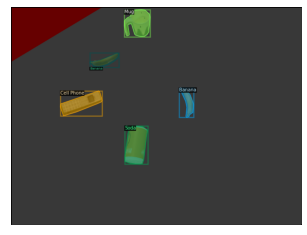

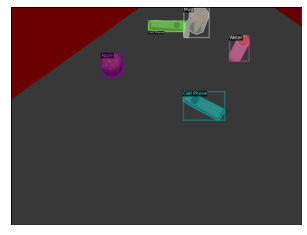

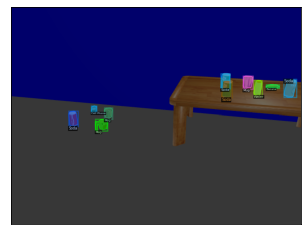

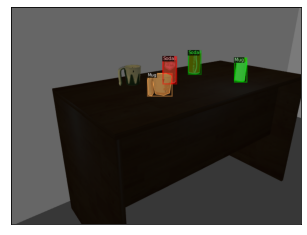

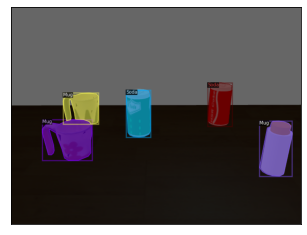

In [9]:
# Show some qualitative results on test set images
NUM_TEST_SAMPLES = 5
samples = random.sample(test_dict, NUM_TEST_SAMPLES)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    visualizer = Visualizer(img, metadata=test_metadata)
    visualizer = visualizer.draw_dataset_dict(sample)
    display_img = visualizer.get_image()[:, :, ::-1]
    plt.figure(i), plt.xticks([]), plt.yticks([])
    plt.imshow(display_img)